# ACTIVIDAD GUIADA 3. OPTIMIZACIÓN


Vamos a partir del estado en el que terminamos en la anterior actividad donde nuestro mejor modelo fue un KNN con 9 características. Cargamos los datasets y seleccionamos esas características, y vamos a probar algoritmos de optimización de parametros.

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns


In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])

train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [ ]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	
                 'precipitation_amt_mm','reanalysis_tdtr_k','reanalysis_min_air_temp_k','station_diur_temp_rng_c']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']

In [ ]:
X_train2 = pd.DataFrame(X_train, columns = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	
                 'precipitation_amt_mm','reanalysis_tdtr_k','reanalysis_min_air_temp_k','station_diur_temp_rng_c'])
X_train2['total_cases'] = train['total_cases']
X_train2

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,precipitation_amt_mm,reanalysis_tdtr_k,reanalysis_min_air_temp_k,station_diur_temp_rng_c,total_cases
0,0.262659,0.314680,0.430091,0.486239,0.056091,0.381614,0.031797,0.086660,0.692308,0.210393,4
1,0.418164,0.489213,0.565350,0.688073,0.031446,0.479668,0.058423,0.069133,0.730769,0.163498,5
2,0.586900,0.657583,0.565350,0.743119,0.045749,0.594415,0.088428,0.064265,0.800000,0.173638,4
3,0.566808,0.643471,0.645897,0.788991,0.024365,0.552387,0.039324,0.073028,0.776923,0.198986,3
4,0.628226,0.701541,0.802432,0.844037,0.021385,0.555396,0.019252,0.112950,0.815385,0.429658,6
...,...,...,...,...,...,...,...,...,...,...,...
1451,0.774093,0.815572,0.769504,0.706422,0.078878,0.758854,0.141577,0.575463,0.584615,0.656950,5
1452,0.726560,0.773236,0.641844,0.642202,0.363015,0.828282,0.221377,0.416748,0.384615,0.529785,8
1453,0.605194,0.665207,0.319149,0.412844,0.088694,0.893932,0.150896,0.418695,0.423077,0.210393,1
1454,0.583143,0.645093,0.429078,0.577982,0.109255,0.903240,0.152765,0.444012,0.384615,0.373046,1


Una vez seleccionado el estado con el que lanzamos el modelo en la AG2, vamos a empezar con un Girdsearch.

Dividimos nuestro dataset de training, a su vez en training y test

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold



cv = KFold(n_splits = 10, shuffle = False) 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = X_train2.loc[train_fold]
          f_test = X_train2.loc[test_fold]

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Y aquí tenemos ambos dataset

In [ ]:

display_side_by_side(f_train.head(),f_test.head())


,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,precipitation_amt_mm,reanalysis_tdtr_k,reanalysis_min_air_temp_k,station_diur_temp_rng_c,total_cases
0,0.262659,0.314680,0.430091,0.486239,0.056091,0.381614,0.031797,0.086660,0.692308,0.210393,4
1,0.418164,0.489213,0.565350,0.688073,0.031446,0.479668,0.058423,0.069133,0.730769,0.163498,5
2,0.586900,0.657583,0.565350,0.743119,0.045749,0.594415,0.088428,0.064265,0.800000,0.173638,4
3,0.566808,0.643471,0.645897,0.788991,0.024365,0.552387,0.039324,0.073028,0.776923,0.198986,3
4,0.628226,0.701541,0.802432,0.844037,0.021385,0.555396,0.019252,0.112950,0.815385,0.429658,6
,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,precipitation_amt_mm,reanalysis_tdtr_k,reanalysis_min_air_temp_k,station_diur_temp_rng_c,total_cases
1311,0.646194,0.703001,0.617021,0.633028,0.060070,0.708427,0.149053,0.752678,0.492308,0.559358,5
1312,0.581836,0.642336,0.684397,0.587156,0.018054,0.508959,0.153072,0.848101,0.446154,0.636248,2
1313,0.700261,0.754420,0.744681,0.633028,0.128536,0.785274,0.095443,0.527751,0.600000,0.720532,6
1314,0.605358,0.659043,0.744681,0.651376,0.067099,0.555151,0.100077,0.698150,0.607692,0.538657,11


Lo primero que vamos a intentar es utilizar gridsearch en un modelo de KNN como el que usamos en la actividad 2. Gridsearch lo que hace es buscar todas las combinaciones de hiperparámetros que le indicamos y las ejecuta todas, devolviendo el mejor modelo, una vez tengamos los mejores estimadores, los utilizaremos para nuestro KNN con los datos de X_train e y_test.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
regressor = neighbors.KNeighborsRegressor() 
regressor

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Definimos los parámetros entre los que buscar y ejecutamos el ajuste

In [ ]:
param_dist = {"leaf_size": [20, 25, 30, 35, 40],
              "algorithm": ['auto', 'ball_tree','kd_tree', 'brute'], 
              "n_neighbors": [20, 25, 28,29,30,31,32,35,40], 
              "weights": ['uniform', 'distance'], 
            }


In [ ]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=5)

# Fit the random search model
grid_regres.fit(X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 25, 30, 35, 40],
                         'n_neighbors': [20, 25, 28, 29, 30, 31, 32, 35, 40],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
report(grid_regres.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 1
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'ball_tree', 'leaf_size': 25, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 1
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'brute', 'leaf_size': 20, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'brute', 'leaf_size': 25, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: -0.830 (std: 1.611)
Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 40, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: -0.830 (st

Ahora vamos a utilizar los parámetros del mejor modelo y haremos la predicción de casos. 

In [ ]:
# constructor
n_neighbors = 40
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, algorithm='ball_tree', leaf_size=20) 
# fit and predict

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred


array([23.1  , 26.9  , 29.9  , 30.9  , 14.725, 37.775, 29.525, 41.4  ,
       28.375, 36.325, 44.05 , 34.55 , 31.1  , 32.125, 47.1  , 42.475,
       41.125, 45.9  , 60.075, 48.225, 49.225, 33.275, 32.15 , 38.9  ,
       36.95 , 31.075, 45.3  , 28.725, 25.85 , 29.975, 29.375, 15.425,
       15.025, 24.175, 15.8  , 15.8  , 17.425, 21.425, 23.525, 39.3  ,
       19.65 , 17.025, 15.5  , 15.775, 15.05 , 13.625, 17.65 , 16.425,
       17.75 , 11.15 , 22.25 , 26.95 , 20.8  , 16.   , 27.575, 36.2  ,
       38.15 , 21.475, 48.275, 40.5  , 76.75 , 39.15 , 29.375, 48.525,
       40.35 , 37.675, 41.85 , 29.55 , 48.925, 52.675, 26.75 , 46.125,
       39.65 , 32.025, 51.8  , 48.5  , 57.   , 40.875, 55.625, 58.65 ,
       29.725, 45.55 , 27.85 , 28.425, 30.675, 31.675, 30.1  , 30.1  ,
       31.425, 21.275, 41.35 , 32.725, 18.1  , 20.025, 26.775, 20.275,
       39.5  , 24.95 , 31.7  , 40.675, 24.975, 21.425, 13.325, 32.95 ,
       27.425, 21.7  , 26.   , 37.9  , 27.6  , 53.05 , 58.075, 40.3  ,
      

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('resultopti.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('resultopti.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,23
1,sj,2008,19,27
2,sj,2008,20,30
3,sj,2008,21,31
4,sj,2008,22,15


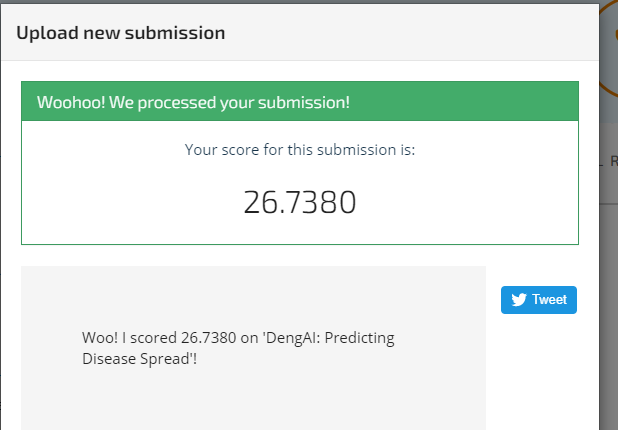![image.png]
)

El resultado ha sido ligeramente superior al del modelo en la AG2, aunque por un margen muy estrecho. En este caso 26.73 frente a 26.74

Aunque el resultado ha sido aceptable al primer intento, vamos a probar también con un RandomSearch, funciona de manera parecida al gridsearch, pero en lugar de ejecutar todas las combinaciones de parámetros, randomiza entre los valores existentes, probando diferentes combinaciones, nosotros podemos elegir el número de iteraciones que queremos que haga. Por lo demás proseguimos de la misma manera que en el apartado anterior.

In [ ]:
param_dist = {"leaf_size": [10, 15, 20, 25, 30, 35, 40],
              "algorithm": ['auto', 'ball_tree','kd_tree', 'brute'], 
              "n_neighbors": [20, 25, 28,29,30,31,32,35,40,45,50], 
              "weights": ['uniform', 'distance'], 
            }

In [ ]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist, 
                               n_iter = 100, cv = 5, random_state=0, n_jobs = -1)

# Fit the random search model
rnd_regres.fit(X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 15, 20, 25, 30, 35,
                                                      40],
                                        'n_neighbors': [20, 25, 28, 29, 30, 31,
                                                        32, 35, 40, 45, 50],
                                        'weights': ['uniform', 'distance']},
       

In [ ]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.823 (std: 1.584)
Parameters: {'weights': 'distance', 'n_neighbors': 50, 'leaf_size': 25, 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: -0.823 (std: 1.584)
Parameters: {'weights': 'distance', 'n_neighbors': 50, 'leaf_size': 15, 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: -0.823 (std: 1.584)
Parameters: {'weights': 'distance', 'n_neighbors': 50, 'leaf_size': 10, 'algorithm': 'auto'}

Model with rank: 4
Mean validation score: -0.823 (std: 1.584)
Parameters: {'weights': 'distance', 'n_neighbors': 50, 'leaf_size': 10, 'algorithm': 'brute'}

Model with rank: 5
Mean validation score: -0.824 (std: 1.580)
Parameters: {'weights': 'uniform', 'n_neighbors': 50, 'leaf_size': 20, 'algorithm': 'auto'}

Model with rank: 5
Mean validation score: -0.824 (std: 1.580)
Parameters: {'weights': 'uniform', 'n_neighbors': 50, 'leaf_size': 20, 'algorithm': 'kd_tree'}



In [ ]:
# constructor
n_neighbors = 50
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, algorithm='kd_tree', leaf_size=25) 
# fit and predict

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred


array([24.18413567, 25.37773507, 36.73409379, 29.28771194, 19.06521582,
       51.10559636, 29.19892146, 58.9552881 , 33.98092202, 36.06972387,
       38.54573863, 49.52777903, 29.41143963, 37.53550534, 48.8282109 ,
       38.14242844, 47.66382085, 47.70261056, 58.30859946, 44.73795416,
       46.36836629, 38.71999134, 34.17355764, 38.49792689, 34.41778573,
       27.86660757, 40.4724055 , 30.65382296, 24.38335459, 29.06805175,
       30.47784934, 15.51243654, 15.45778179, 24.11098008, 15.6971652 ,
       15.6971652 , 16.67175868, 23.68612266, 22.51409158, 33.31129015,
       19.25784353, 17.41847181, 14.03727632, 14.89781782, 15.26941033,
       13.46173488, 17.80252249, 15.20532634, 16.57090101, 13.56538631,
       19.53734604, 21.83257019, 21.00696734, 17.74042998, 25.29470361,
       33.32068273, 34.31009617, 20.44682684, 46.21414307, 37.10621787,
       71.79616891, 42.96828773, 33.78523225, 45.82867371, 37.7390824 ,
       33.04703163, 43.33775636, 37.84249833, 45.59629768, 54.31

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('resultopti2.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('resultopti2.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,24
1,sj,2008,19,25
2,sj,2008,20,37
3,sj,2008,21,29
4,sj,2008,22,19


En esta ocasión el resultado es ligeramente peor, ya que ha empeorado hasta 26'83. 

En resumen, utilizando el KNN con Gridsearch y Randomsearch hemos obtenido resultados bastante similares tanto entre si como a los resultados que ya obtuvimos haciendo el modelo "a ojo", lo cual nos sigue sugiriendo que en el caso de este dataset, el factor limitante está en el preproceso de los datos más que en el modelo.

Vamos a probar con un Random Forest.

In [ ]:
regressor = RandomForestRegressor() 
regressor

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
param_dist = {"n_estimators": [32, 48, 64, 96, 128], 
              "max_features": ['auto', 'sqrt'], 
              "max_depth": [8,4, 2], 
              "min_samples_split": [2, 4, 6], 
              "min_samples_leaf": [8, 12, 16], 
              "bootstrap": [True, False] 
            }

In [ ]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=5)

# Fit the random search model
grid_regres.fit(X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
report(grid_regres.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: -0.705 (std: 1.351)
Parameters: {'bootstrap': True, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 48}

Model with rank: 2
Mean validation score: -0.734 (std: 1.551)
Parameters: {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 64}

Model with rank: 3
Mean validation score: -0.735 (std: 1.384)
Parameters: {'bootstrap': True, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 48}

Model with rank: 4
Mean validation score: -0.741 (std: 1.464)
Parameters: {'bootstrap': False, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 64}

Model with rank: 5
Mean validation score: -0.742 (std: 1.568)
Parameters: {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_est

In [ ]:
grid_regres.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=16,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=48, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)
y_pred

array([21.17067178, 22.35954275, 18.49223253, 20.2173789 , 31.4690444 ,
       41.77306784, 36.75585214, 33.89910184, 42.990767  , 43.73455587,
       41.37382019, 43.35241176, 43.73455587, 42.97487611, 46.60010659,
       42.97487611, 46.70128647, 46.27385709, 51.26480266, 50.51485772,
       44.59886206, 39.32595918, 38.86127277, 43.50074808, 36.72794951,
       39.91280911, 38.14849095, 43.73985934, 39.55024426, 42.51081879,
       33.48152973, 21.01544338, 23.44289562, 28.47578348, 19.93113286,
       19.93113286, 19.33050393, 27.91055744, 21.43672425, 22.94856215,
       20.8697057 , 22.37957169, 22.11154731, 22.0202953 , 20.68018227,
       22.11154731, 22.28831968, 19.58971735, 19.45858315, 20.77845369,
       20.92231958, 20.92231958, 23.44289562, 21.01357159, 30.14985651,
       24.64235875, 40.12314364, 36.68298451, 40.94831802, 41.17550598,
       43.46302894, 36.61410353, 41.2639456 , 44.31127124, 43.72574114,
       42.990767  , 45.07923315, 45.07923315, 47.67724283, 44.74

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('resultopti3.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('resultopti3.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,21
1,sj,2008,19,22
2,sj,2008,20,18
3,sj,2008,21,20
4,sj,2008,22,31


El resultado es 26.87, lo cual no mejora, e incluso empeora los resultados anteriores.

In [ ]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist, 
                               n_iter = 100, cv = 5, random_state=0, n_jobs = -1)

# Fit the random search model
rnd_regres.fit(X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.779 (std: 1.500)
Parameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': False}

Model with rank: 2
Mean validation score: -0.784 (std: 1.549)
Parameters: {'n_estimators': 32, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': True}

Model with rank: 3
Mean validation score: -0.789 (std: 1.658)
Parameters: {'n_estimators': 96, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': 'auto', 'max_depth': 2, 'bootstrap': True}

Model with rank: 4
Mean validation score: -0.795 (std: 1.570)
Parameters: {'n_estimators': 32, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': False}

Model with rank: 5
Mean validation score: -0.802 (std: 1.680)
Parameters: {'n_estimators': 96, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 2, 'boots

In [ ]:
rnd_regres.best_params_

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 64}

In [ ]:
# choose the best
best_random = rnd_regres.best_estimator_

# fit and predict
best_random.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)
y_pred

array([21.17067178, 22.35954275, 18.49223253, 20.2173789 , 31.4690444 ,
       41.77306784, 36.75585214, 33.89910184, 42.990767  , 43.73455587,
       41.37382019, 43.35241176, 43.73455587, 42.97487611, 46.60010659,
       42.97487611, 46.70128647, 46.27385709, 51.26480266, 50.51485772,
       44.59886206, 39.32595918, 38.86127277, 43.50074808, 36.72794951,
       39.91280911, 38.14849095, 43.73985934, 39.55024426, 42.51081879,
       33.48152973, 21.01544338, 23.44289562, 28.47578348, 19.93113286,
       19.93113286, 19.33050393, 27.91055744, 21.43672425, 22.94856215,
       20.8697057 , 22.37957169, 22.11154731, 22.0202953 , 20.68018227,
       22.11154731, 22.28831968, 19.58971735, 19.45858315, 20.77845369,
       20.92231958, 20.92231958, 23.44289562, 21.01357159, 30.14985651,
       24.64235875, 40.12314364, 36.68298451, 40.94831802, 41.17550598,
       43.46302894, 36.61410353, 41.2639456 , 44.31127124, 43.72574114,
       42.990767  , 45.07923315, 45.07923315, 47.67724283, 44.74

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('resultopti4.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('resultopti4.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,21
1,sj,2008,19,22
2,sj,2008,20,18
3,sj,2008,21,20
4,sj,2008,22,31


El resultado obtenido vuelve a ser de 26.87, por lo que no ha mejorado nada, pero se sigue manteniendo en valores parecidos.

## Conclusiones

Como conclusión de las tres actividades, la mejor medida del indicador de error usado (el MAE) que proporciona la competición es 26.73, ésta es una medida que considero aceptable pues nuestro primer intento fue de 30 altos, e incluso en posteriores intentos llegamos a obtener 39. Además hemos trabajado con PCA y DBSCAN para la selección de características, luego hemos aplicado otros algoritmos e aprendizaje supervisado como regresión lineal, árboles de decisión, random forest y KNN.

Sin embargo, soy consciente de que, incluso con estos modelos se podría obtener resultados mejores, al menos mejorar un punto sin problemas. El factor diferencial de este problema es la selección de características y el preprocesado de datos, investigando un poco más sobre las características podríamos lograr una mejor combinación, además estoy seguro que diviendo el dataset por ambas ciudades y realizando un modelo para cada una de ellas, mejoraríamos bastante los resultados. Quedaría pendiente también utilizar algún algoritmo como catboost o xgboost para ver que resultados arroja. Lo dejo como proyecto a futuro cuando tenga más disponibilidad de tiempo.